# EDA: Amazon Review Datasets

In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json

## Load data

In [2]:
def parse_json(path):
    with open(path, "r") as g:
        lines = g.readlines()
        for line in lines:
            yield json.loads(line)

def parse_gz(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def get_df(path, parser):
    i = 0
    df = {}
    for d in parser(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

# Load data
meta_data = get_df('../datasets/meta_All_Beauty.json.gz', parse_gz)
json_data = [item for item in parse_json("../datasets/All_Beauty.json")]
review_data = pd.DataFrame(json_data)
rating_data = pd.read_csv("../datasets/ratings_Beauty.csv", 
                          names=["item", "user", "rating", "timestamp"],
                          index_col="timestamp")
print(f"{meta_data.shape=}")
print(f"{review_data.shape=}")
print(f"{rating_data.shape=}")

meta_data.shape=(32892, 19)
review_data.shape=(371345, 12)
rating_data.shape=(2023070, 3)


/Users/ntphuong/miniconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Meta data

In [3]:
meta_data.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


## Data Preprocessing

In [4]:
# Keeping features
features = ["asin",
            "title",
            "also_buy",
            "brand",
            "also_view",
            "price"]
meta_data = meta_data[features]

In [5]:
# Find which asin occur more than once
meta_data['asin'].value_counts() > 1

B00028EZZG     True
B000158MEA     True
B0001428BY     True
B0002IETRU     True
B0002564EE     True
              ...  
B00EWUFETQ    False
B00FOGXMQY    False
B008MBGX78    False
B00MNAKERY    False
B000HTBAF8    False
Name: asin, Length: 32488, dtype: bool

In [6]:
# We can see that rows with more than once occurs are duplicates
meta_data[meta_data['asin'] == "B000158MEA"]

,asin,title,also_buy,brand,also_view,price
204,B000158MEA,"Nutrition Supply - Nsc-24 Immuskin, 2 oz cream",[],Nutrition Supply,"[B000Z91L68, B0014AUUUA, B0002JKEKK, B0001542G...",$29.95
608,B000158MEA,"Nutrition Supply - Nsc-24 Immuskin, 2 oz cream",[],Nutrition Supply,"[B000Z91L68, B0014AUUUA, B0002JKEKK, B0001542G...",$29.95


In [7]:
# Drop duplicates and set `asin` as index
meta_data = meta_data.drop_duplicates(subset="asin").set_index("asin")

In [8]:
str2float = lambda x: float(x[1:]) if x != "" else 0.
is_price = lambda x: len(x) > 8
# drop rows with non-priced values
meta_data = meta_data.drop(meta_data[meta_data["price"].apply(is_price)].index)

# Convert string to float for price column
meta_data['price'] = meta_data['price'].apply(str2float)
meta_data.head()

,title,also_buy,brand,also_view,price
asin,,,,,
6546546450,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,[],0.00
7178680776,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,[],44.99
7250468162,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,"[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]",28.76
7367905066,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,[],0.00
7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...",12.15


In [9]:
# Fill missing values in brand column with "other"
meta_data['brand'] = meta_data['brand'].replace("", "other")
meta_data.head()

,title,also_buy,brand,also_view,price
asin,,,,,
6546546450,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,[],0.00
7178680776,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",other,[],44.99
7250468162,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,"[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]",28.76
7367905066,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],other,[],0.00
7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...",12.15


## Data Exploratory

In [10]:
# Number of brands including "other"
meta_data['brand'].unique().shape[0]

7827

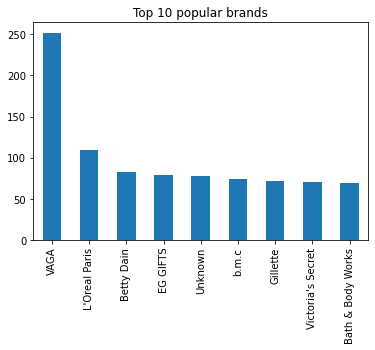

In [11]:
# Plot brands with the most number of products
top10_popular = meta_data['brand'].value_counts()[1:10]
top10_popular.plot.bar()
plt.title("Top 10 popular brands")
plt.show()

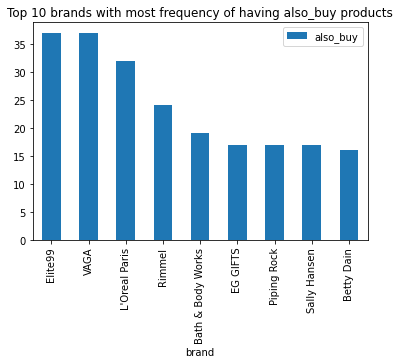

In [12]:
# Count number of products of a brand that have also_buy product
also_buy_brands = meta_data[meta_data['also_buy'].apply(lambda x: len(x) > 0)]\
                            .groupby('brand')\
                            .agg({'also_buy': 'count'})\
                            .sort_values('also_buy', ascending=False)
also_buy_brands[1:10].plot.bar()
plt.title("Top 10 brands with most frequency of having also_buy products")
plt.show()

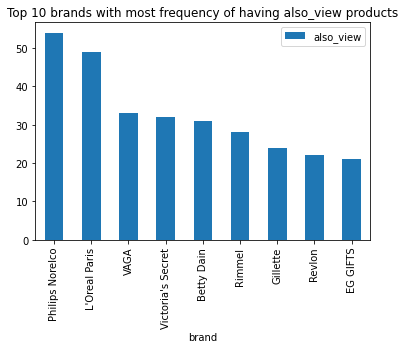

In [13]:
# Count number of products of a brand that have also_view product
also_view_brands = meta_data[meta_data['also_view'].apply(lambda x: len(x) > 0)]\
                            .groupby('brand')\
                            .agg({'also_view': 'count'})\
                            .sort_values('also_view', ascending=False)
also_view_brands[1:10].plot.bar()
plt.title("Top 10 brands with most frequency of having also_view products")
plt.show()

In [14]:
review_data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5.0,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5.0,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN


In [15]:
rating_products = review_data.groupby('asin').agg({'reviewerID': 'count', 'overall': 'mean'}).sort_values(['reviewerID', 'overall'], ascending=False)
rating_products.head()

,reviewerID,overall
asin,,
B000FOI48G,8672,4.393450
B000GLRREU,8341,4.405107
1620213982,4792,4.798414
B001QY8QXM,4544,4.556118
B01DKQAXC0,4246,4.209138


We only count number of reviews and calculate mean overall of each product

In [16]:
# We join two columns of #reviews and average overall in the meta data table
new_data = meta_data.join(rating_products, how='inner').rename(columns={'reviewerID': 'no_reviews'})
new_data.sort_values("no_reviews", ascending=False)

,title,also_buy,brand,also_view,price,no_reviews,overall
asin,,,,,,,
B000FOI48G,Waterpik Ultra Water Flosser,"[B003FSTE4W, B001NIZ5U8, B00CU9VF2Q, B0062N798...",Waterpik,"[B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...",0.00,8672,4.393450
B000GLRREU,Waterpik Ultra Water Flosser,"[B003FSTE4W, B001NIZ5U8, B00CU9VF2Q, B0062N798...",Waterpik,"[B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...",0.00,8341,4.405107
B001QY8QXM,Astra Platinum Double Edge Safety Razor Blades...,[],Astra,"[B00DQ2W7UK, B00PKHIDRA, B07CGMTVM4, B07MB4LZC...",9.30,4544,4.556118
B01DKQAXC0,Bali Secrets Natural Deodorant - Organic &amp;...,"[B07DNGSBSC, B00EOB0042, B077F4NB55, B07GXZYBX...",other,[],0.00,4246,4.209138
B00W259T7G,Pre de Provence Artisanal French Soap Bar Enri...,[],Pre de Provence,"[B01CUB6GB8, B074MHH469, B07J2CCWP1, B074MHWMV...",4.99,2959,4.516729
...,...,...,...,...,...,...,...
B013B9I1X4,Philips Cleansing brush Visa Pure Tapping head...,"[B013B9I12A, B00EPT7HJO, B00K7R1F00]",Phillips,"[B015OL5JC8, B01854ZAPM, B00OPUH69E, B013B9I12...",51.06,1,5.000000
B00GEDZEJE,Spa Technologies Regenerative Oil,[],Spa Technologies,"[B000Z5YCYK, B00Q4MZO1S, B07CYDT7JK, B000Z61PV...",60.00,1,5.000000
B00GDF76V2,Awesome Human Wig Leave-in Conditioning Spray ...,[],other,[],0.00,1,5.000000


In [17]:
new_data['no_also_buy'] = new_data["also_buy"].apply(lambda x : len(x))
new_data['no_also_view'] = new_data["also_view"].apply(lambda x : len(x))
new_data.head()

,title,also_buy,brand,also_view,price,no_reviews,overall,no_also_buy,no_also_view
asin,,,,,,,,,
6546546450,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,[],0.00,2,2.5,0,0
7178680776,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",other,[],44.99,1,3.0,2,0
7250468162,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,"[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]",28.76,1,5.0,0,3
7367905066,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],other,[],0.00,1,5.0,1,0
7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...",12.15,15,4.4,0,57


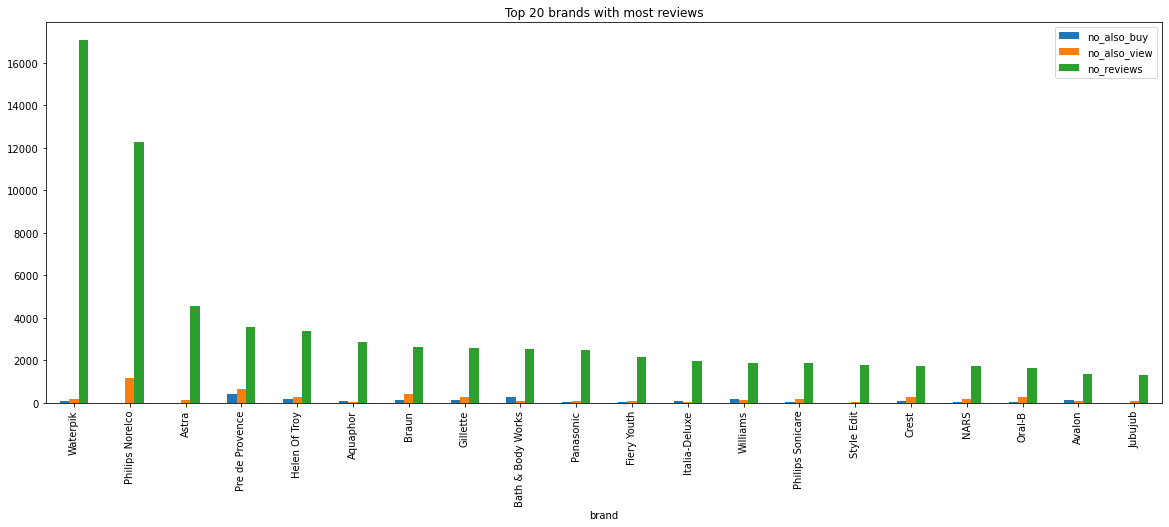

In [23]:
brands = new_data.groupby('brand')\
    .agg({"no_also_buy": 'sum',
          "no_also_view": "sum",
          "no_reviews": 'sum'})\
    .sort_values("no_reviews", ascending=False)

brands[1:21].plot.bar(figsize=(20,7))
plt.title("Top 20 brands with most reviews")
plt.show()

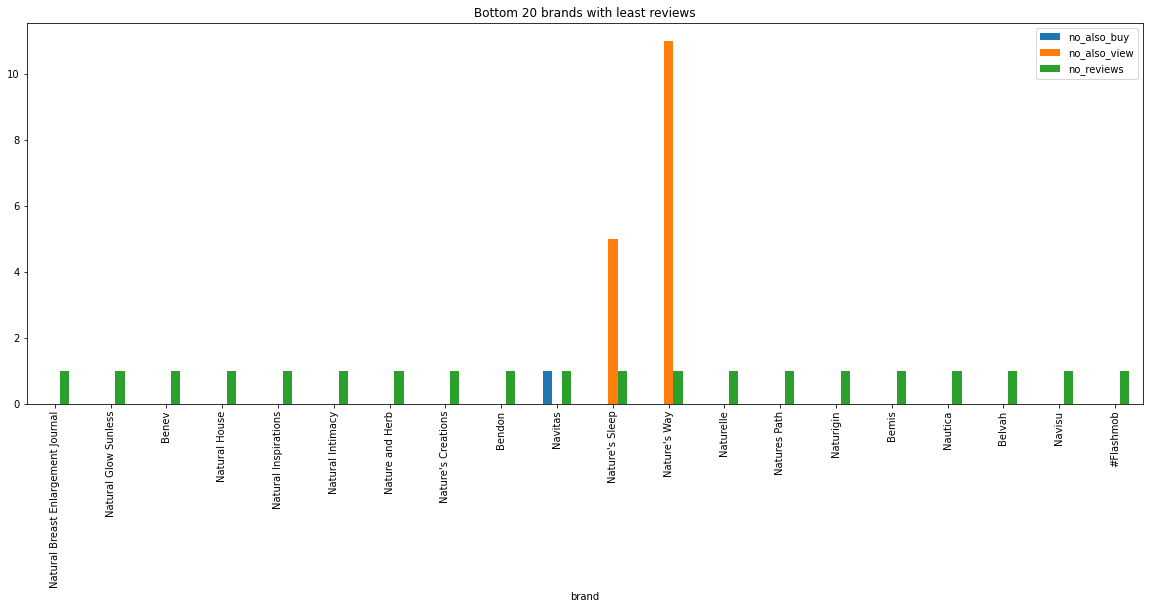

In [22]:
brands[-20:].plot.bar(figsize=(20,7))
plt.title("Bottom 20 brands with least reviews")
plt.show()

<AxesSubplot:>

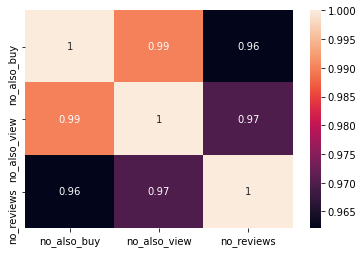

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(brands)
scaled_brands_df = pd.DataFrame(X, columns=["no_also_buy", "no_also_view", "no_reviews"])
sns.heatmap(scaled_brands_df.corr(), annot=True)

There are correlations between no_reviews and no_also_buy, no_reviews and no_also_view. Therefore, no_reviews might be an important feature in our model.